https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html



WHAT YOU ARE GOING TO DO NEXT TIME:
* open lab4 on git
* generate image for SIFT:
    * no plate numbers
    * no spot number
* use this to compare to photo of license plate.
* If there is a good enough connection then create homography and draw rectangle
* Stretch, warp and scale image
* cut image into sections
* train on inputted image
* save policy 


https://www.pyimagesearch.com/2014/05/05/building-pokedex-python-opencv-perspective-warping-step-5-6/

https://stackoverflow.com/questions/43382045/keras-realtime-augmentation-adding-noise-and-contrast


In [ ]:
import string
import random
from random import randint
import cv2
import numpy as np
import os
import re

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image, ImageFont, ImageDraw
%tensorflow_version 1.14.0
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend
from keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow

!pip install opencv-contrib-python==4.3.0.38
print(cv2.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


     |████████████████████████████████| 55.4MB 55kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


4.1.2


In [ ]:
# Run this command only once:

# makes the output folder /content/pictures/
!rm -rf pictures
!rm -rf warpedpictures
!mkdir pictures
!mkdir warpedpictures

In [ ]:
# Run this command only once

# Downloads the license plate template to /content/blank_plate.png
!gdown --id 1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v

Downloading...
From: https://drive.google.com/uc?id=1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v
To: /content/blank_plate.png
100% 144k/144k [00:00<00:00, 44.7MB/s]


EV 90


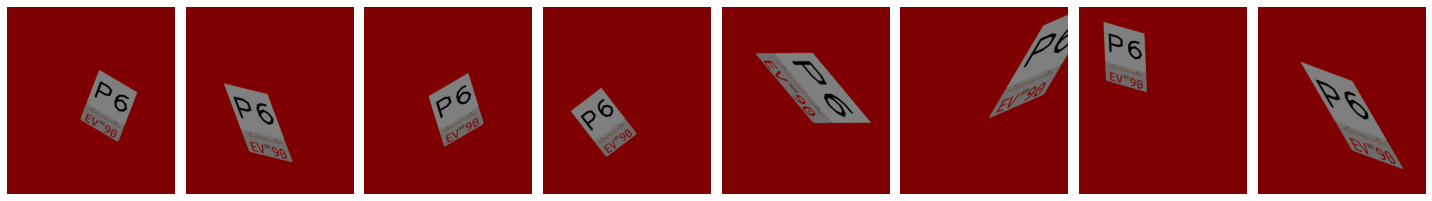

In [ ]:
path = "/content/"

NUMBER_OF_PLATES = 150


for i in range(0, NUMBER_OF_PLATES):

    # Pick two random letters
    plate_alpha = ""
    for _ in range(0, 2):
        plate_alpha += (random.choice(string.ascii_uppercase))

    # Pick two random numbers
    num = randint(0, 99)
    plate_num = "{:02d}".format(num)

    # Write plate to image
    blank_plate = cv2.imread(path+'blank_plate.png')

    # Convert into a PIL image (this is so we can use the monospaced fonts)
    blank_plate_pil = Image.fromarray(blank_plate)
    #blank_plate_pil_blank = Image.fromarray(blank_plate)

    # Get a drawing context
    draw = ImageDraw.Draw(blank_plate_pil)

    monospace = ImageFont.truetype("/content/drive/MyDrive/ENPH353/UbuntuMono-R.ttf", 200)
    draw.text((48, 105),plate_alpha + " " + plate_num, (255,0,0), font=monospace)

    # Convert back to OpenCV

    blank_plate = np.asarray([np.array(blank_plate_pil)])

    # Create parking spot label
    spotindex = i%8 + 1

    # #s_blank = "P"
    # #parking_spot_blank = 255 * np.ones(shape=[600, 600, 3], dtype=np.uint8)
    # #cv2.putText(parking_spot_blank, s_blank, (30, 450), cv2.FONT_HERSHEY_PLAIN, 28,
    #             (0, 0, 0), 30, cv2.LINE_AA)
    # spot_w_blank_plate = np.concatenate((parking_spot_blank, blank_plate_pil_blank), axis=0)
    # cv2.imwrite(os.path.join(path + "drive/MyDrive/ENPH353", 
    #                        "aplate_{}.png".format("blank")),
    #                        spot_w_blank_plate)

    s = "P" + str(spotindex)
    parking_spot = 255 * np.ones(shape=[600, 600, 3], dtype=np.uint8)
    cv2.putText(parking_spot, s, (30, 450), cv2.FONT_HERSHEY_PLAIN, 28,
                (0, 0, 0), 30, cv2.LINE_AA)
    spot_w_plate = np.concatenate((parking_spot, blank_plate_pil), axis=0)
    spot_w_plate = cv2.copyMakeBorder(spot_w_plate,1000,1000,1000,1000,cv2.BORDER_CONSTANT,value=[255,0,0])
    w = spot_w_plate.shape[1]
    h = spot_w_plate.shape[0]
    rescale = (int(w*0.22), int(h*0.22))
    spot_w_plate = cv2.resize(spot_w_plate, rescale, interpolation = cv2.INTER_AREA)

    # Convert back to OpenCV image and save
    # plate_numbersletters_parkingspot_variation.png
    cv2.imwrite(os.path.join(path + "pictures/", 
                             "plate_{}{}_{}_{}.png".format(plate_alpha, plate_num, spotindex, 0)),
                             spot_w_plate)
    spot_w_plate = np.asarray([np.array(spot_w_plate)])
    #test function
    def plotImages(images_arr):
      fig, axes = plt.subplots(1, 8, figsize=(20,20))
      axes = axes.flatten()
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
      plt.tight_layout()
      plt.show()


    # Create data augmentor from Keras
    datagen = ImageDataGenerator(
      featurewise_center=False,
      samplewise_center=False,
      featurewise_std_normalization=False,
      samplewise_std_normalization=False,
      zca_whitening=False,
      zca_epsilon=1e-06,
      rotation_range=40,
      width_shift_range=0.25,
      height_shift_range=0.25,
      brightness_range=None,
      shear_range=60,
      zoom_range=0,
      channel_shift_range=0.0,
      fill_mode="nearest",
      cval=0.0,
      horizontal_flip=False,
      vertical_flip=False,
      rescale=0.5,
      preprocessing_function=None,
      data_format=None,
      validation_split=0.3,
      dtype=None,)
    
    aug_iter = datagen.flow(spot_w_plate)
    aug_plates = [next(aug_iter)[0].astype(np.uint8) for k in range(8)]
    # Write augmented license plates to file
    for j in range(0,7):
      cv2.imwrite(os.path.join(path + "pictures/", 
                             "plate_{}{}_{}_{}.png".format(plate_alpha, plate_num,spotindex, j+1)),
                             aug_plates[j])
print(plate_alpha + " " + plate_num)
plotImages(aug_plates)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = "/content/pictures/"
labels = !ls "{PATH}"
labels = labels[0].split()


In [ ]:
def files_in_folder(folder_path):
  '''
  Returns a list of strings where each entry is a file in the folder_path.
  
  Parameters
  ----------
  
  folder_path : str
     A string to folder for which the file listing is returned.
     
  '''
  files_A = !ls "{folder_path}"
  # The files when listed from Google Drive have a particular format. They are
  # grouped in sets of 4 and have spaces and tabs as delimiters.
  
  # Split the string listing sets of 4 files by tab and space and remove any 
  # empty splits.
  files_B = [list(filter(None, re.split('\t|\s', files))) for files in files_A]
  
  # Concatenate all splits into a single sorted list
  files_C = []
  for element in files_B:
    files_C = files_C + element
  files_C.sort()
  
  return files_C

folder = PATH
dataset = files_in_folder(folder)
print(dataset)
print(len(dataset))
generated_dataset_size = len(dataset)


['plate_AA06_3_0.png', 'plate_AA06_3_1.png', 'plate_AA06_3_2.png', 'plate_AA06_3_3.png', 'plate_AA06_3_4.png', 'plate_AA06_3_5.png', 'plate_AA06_3_6.png', 'plate_AA06_3_7.png', 'plate_AE15_7_0.png', 'plate_AE15_7_1.png', 'plate_AE15_7_2.png', 'plate_AE15_7_3.png', 'plate_AE15_7_4.png', 'plate_AE15_7_5.png', 'plate_AE15_7_6.png', 'plate_AE15_7_7.png', 'plate_BJ57_6_0.png', 'plate_BJ57_6_1.png', 'plate_BJ57_6_2.png', 'plate_BJ57_6_3.png', 'plate_BJ57_6_4.png', 'plate_BJ57_6_5.png', 'plate_BJ57_6_6.png', 'plate_BJ57_6_7.png', 'plate_BJ57_7_0.png', 'plate_BJ57_7_1.png', 'plate_BJ57_7_2.png', 'plate_BJ57_7_3.png', 'plate_BJ57_7_4.png', 'plate_BJ57_7_5.png', 'plate_BJ57_7_6.png', 'plate_BJ57_7_7.png', 'plate_BQ37_6_0.png', 'plate_BQ37_6_1.png', 'plate_BQ37_6_2.png', 'plate_BQ37_6_3.png', 'plate_BQ37_6_4.png', 'plate_BQ37_6_5.png', 'plate_BQ37_6_6.png', 'plate_BQ37_6_7.png', 'plate_BT82_6_0.png', 'plate_BT82_6_1.png', 'plate_BT82_6_2.png', 'plate_BT82_6_3.png', 'plate_BT82_6_4.png', 'plate_BT

SIFT TIME

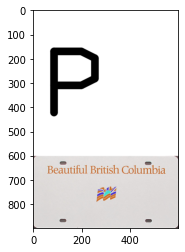

In [ ]:
path = "/content/"
sift = cv2.xfeatures2d.SIFT_create()
img_colour = cv2.imread(path + "drive/MyDrive/ENPH353/aplate_blank.png")
#print(PATH + dataset[0])
plt.imshow(img_colour)
targetheight, targetwidth, _ = img_colour.shape
img = cv2.cvtColor(img_colour, cv2.COLOR_BGR2GRAY)

kp_image, desc_image = sift.detectAndCompute(img, None)
# Feature matching
index_params = dict(algorithm=0, trees=5)
search_params = dict()
flann = cv2.FlannBasedMatcher(index_params, search_params)
for i in range(1,len(dataset)):
    frame = cv2.imread(PATH + dataset[i])
    #plate_{}{}_{}_{}.png
    #print(dataset[i])
    plate_alpha = dataset[i][6:8]
    #print(plate_alpha)
    plate_num = dataset[i][8:10]
    #print(plate_num)
    spotindex = dataset[i][11:12]
    #print(spotindex)


    grayframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # trainimage
    kp_grayframe, desc_grayframe = sift.detectAndCompute(grayframe, None)
    matches = flann.knnMatch(desc_image, desc_grayframe, k=2)
    good_points = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:
            good_points.append(m)

    if len(good_points) > 12:
        query_pts = np.float32([kp_image[m.queryIdx].pt for m in good_points]).reshape(-1, 1, 2)
        train_pts = np.float32([kp_grayframe[m.trainIdx].pt for m in good_points]).reshape(-1, 1, 2)
        matrix, mask = cv2.findHomography(query_pts, train_pts, cv2.RANSAC, 5.0)
        matches_mask = mask.ravel().tolist()

        # Perspective transform
        h, w = img.shape
        pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, matrix)
        #print(np.int32(dst))
        homography = cv2.polylines(frame, [np.int32(dst)], True, (255, 0, 0), 3)
        # plt.figure(str(i) + "matched")
        # plt.imshow(frame)
        # plt.show()
        
        #If plate is identified, stretch it and save it.
        rect_pts = np.int32(dst).reshape(4,2)
        rect = np.zeros((4,2), dtype = "float32")
        # the top-left point has the smallest sum whereas the
        # bottom-right has the largest sum
        s = rect_pts.sum(axis = 1)
        rect[0] = rect_pts[np.argmin(s)]
        rect[2] = rect_pts[np.argmax(s)]
        # compute the difference between the points -- the top-right
        # will have the minumum difference and the bottom-left will
        # have the maximum difference
        diff = np.diff(rect_pts, axis = 1)
        rect[1] = rect_pts[np.argmin(diff)]
        rect[3] = rect_pts[np.argmax(diff)]

        # now that we have our rectangle of points, let's compute
        # the width of our new image
        (tl, tr, br, bl) = rect
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        # ...and now for the height of our new image
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        # take the maximum of the width and height values to reach
        # our final dimensions
        maxWidth = max(int(widthA), int(widthB))
        maxHeight = max(int(heightA), int(heightB))
        # construct our destination points which will be used to
        # map the screen to a top-down, "birds eye" view
        dst = np.array([
          [0, 0],
          [targetwidth - 1, 0],
          [targetwidth - 1, targetheight - 1],
          [0, targetheight - 1]], dtype = "float32")
        # calculate the perspective transform matrix and warp
        # the perspective to grab the screen
        M = cv2.getPerspectiveTransform(rect, dst)
        warp = cv2.warpPerspective(frame, M, (targetwidth, targetheight))

        # plt.figure(str(i) + "warped")
        # plt.imshow(warp)
        # plt.show()

        cv2.imwrite(os.path.join(path + "warpedpictures/", 
                             "plate_{}{}_{}_{}.png".format(plate_alpha, plate_num,spotindex, i % 8 + 1)),
                             warp)
    else:
        
        framenotmatched = cv2.drawMatches(img, kp_image, grayframe, kp_grayframe, good_points, grayframe)
        # plt.figure(str(i) + "notmatched")
        # plt.imshow(framenotmatched)
        # plt.show()


In [ ]:
folder = "/content/warpedpictures"
warpeddataset = files_in_folder(folder)
imgset = np.array([np.array((f'{folder}/{file}'))
                    for file in warpeddataset[:]])
print("Loaded {:} images from folder:\n{}".format(imgset.shape[0], folder))


Loaded 257 images from folder:
/content/warpedpictures


In [ ]:
print(generated_dataset_size)
print(imgset.shape[0])
print(str(imgset.shape[0]/generated_dataset_size*100) + "% of generated images detected and warped")

1200
257
21.416666666666668% of generated images detected and warped


In [ ]:
X_dataset = []
Y_dataset = []

print(imgset[0])
np.random.shuffle(imgset)
#parses image and adds labels/images to dataset
def croplicenseimage( plate):
    im = Image.open(plate)
    w,h = im.size
    # print(h)
    # print(w)
    index = 0
    #split spot number and plate into seperate images
    for index in range (0,4):
      area = (w*index/4, 2*h/3, w*index/4 + w/4, h)
      cim = im.crop(area)
      imagename = plate[len(plate) - 12 + index] + "_" + str(index) + ".png"
      
      #ignoring index of image
      _, onehotlabel =  labelimage(imagename)

      Y_dataset.append(onehotlabel)
      X_dataset.append(cim)
      # plt.figure(i)
      # plt.title(imagename)
      # plt.imshow(cim)
      # plt.show()

    
    area = (w/2, 0, w, 2*h/3)
    cim_pre = im.crop(area)
    dim = (int(w/4), int(h/3))
    cim = cv2.resize(np.asarray(cim_pre), dim)
    imagename = plate[len(plate) - 7] + "_" + str(0) + ".png"
      
    #ignoring index of image
    _, onehotlabel =  labelimage(imagename)

    Y_dataset.append(onehotlabel)
    X_dataset.append(cim)
    # plt.figure(i+4)
    # plt.title(imagename)
    # plt.imshow(cim)
    # plt.show()

#create one hot key for given cropped image.
#return the 'index' of the number on the plate and return the 'label' that hold the vector of the inputted image.

def labelimage(plateID):
    encodingkey = {'A' : 0, 'B': 1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9, 'K':10, 'L':11, 'M':12, 'N':13, 'O':14, 'P':15, 'Q':16, 'R':17, 'S':18, 'T':19,'U':20,'V':21, 'W':22, 'X':23, 'Y':24, 'Z':25,'0': 26,'1':27,'2':28, '3':29, '4':30, '5':31,'6':32, '7':33,'8':34, '9':35}
    plate = plateID[0]
    index = plateID[2]
    label = np.zeros(36)
    label[encodingkey[str(plate)]] = 1
    return index, label


for img in imgset[:]:
    croplicenseimage(img)

print(Y_dataset[0])

X_dataset2 = [np.asarray(i)/255 for i in X_dataset]
X_dataset2 = np.asarray(X_dataset2)
Y_dataset2 = np.asarray(Y_dataset)


print(X_dataset2.shape)
print(Y_dataset2.shape)

/content/warpedpictures/plate_AA06_3_8.png
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1285, 299, 150, 3)
(1285, 36)


In [ ]:
VALIDATION_SPLIT = 0.2
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [ ]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(299,150,3)))
conv_model.add(layers.MaxPooling2D((2,2)))
conv_model.add(layers.Conv2D(64,(3,3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2,2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(36,activation='softmax'))

LEARNING_RATE = 1e-6
conv_model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=LEARNING_RATE),metrics=['acc'])
conv_model.summary()

EPOCHS = 20
BATCHES = 40
reset_weights(conv_model) #do if ya want
history_conv = conv_model.fit(X_dataset2, Y_dataset2, validation_split=VALIDATION_SPLIT, epochs=EPOCHS, batch_size=BATCHES)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 297, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 148, 74, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 146, 72, 64)       18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 73, 36, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 168192)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 168192)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

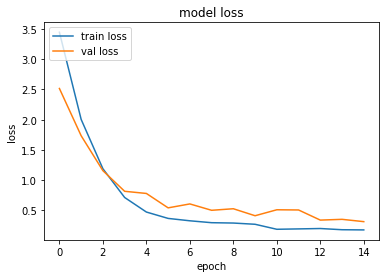

In [ ]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

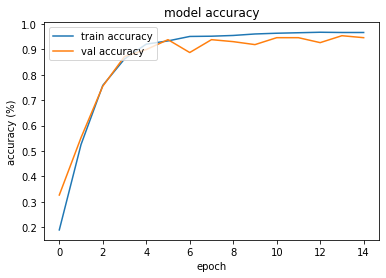

In [ ]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

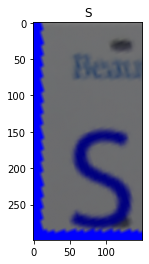

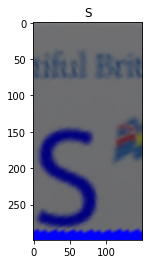

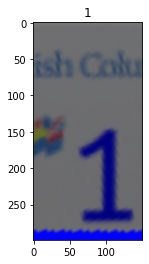

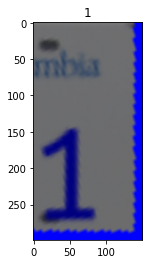

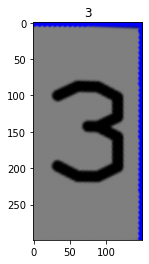

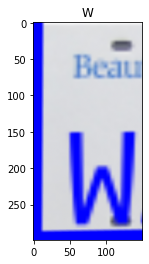

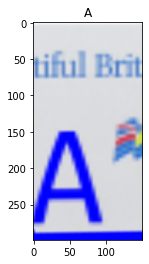

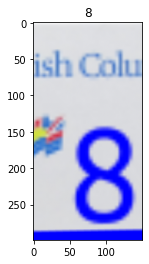

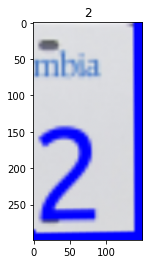

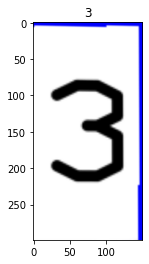

In [ ]:
def displayImage(index):
  img = X_dataset2[index]
  
  img_aug = np.expand_dims(img, axis=0)
  y_predict = conv_model.predict(img_aug)[0]
  plt.imshow(img)  
  encodingkey = {'A' : 0, 'B': 1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9, 'K':10, 'L':11, 'M':12, 'N':13, 'O':14, 'P':15, 'Q':16, 'R':17, 'S':18, 'T':19,'U':20,'V':21, 'W':22, 'X':23, 'Y':24, 'Z':25,'0': 26,'1':27,'2':28, '3':29, '4':30, '5':31,'6':32, '7':33,'8':34, '9':35}
  inv_map = {v: k for k, v in encodingkey.items()}
  caption = inv_map[np.argmax(y_predict)]
  plt.title(str(caption))

# interact(displayImage, 
#         index=ipywidgets.IntSlider(min=0, max=X_dataset_orig.shape[0],
#                                    step=1, value=10))
for i in range(10,20):
    plt.figure(i)
    displayImage(i)

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

def predictimage():
  y_predict = []

  for index in range(0,len(Y_dataset2)):
    img = X_dataset2[index]
    img_aug = np.expand_dims(img, axis=0)
    y_predict.append(np.argmax(conv_model.predict(img_aug)[0]))
  return y_predict

y_predict = np.round(predictimage(),0)
yreal = []
for i in range(0,len(Y_dataset2)):
    yreal.append(np.argmax(Y_dataset2[i]))





[19, 15, 28, 33, 29, 9, 16, 26, 32, 29, 12, 16, 27, 32, 29, 21, 6, 34, 27, 30, 2, 21, 26, 34, 27, 20, 11, 33, 31, 27, 16, 13, 26, 29, 33, 6, 16, 26, 26, 27, 4, 24, 26, 31, 30, 21, 9, 32, 28, 30, 17, 1, 27, 28, 30, 14, 21, 32, 34, 29, 21, 24, 34, 27, 30, 4, 24, 26, 31, 30, 17, 15, 27, 30, 28, 16, 24, 34, 30, 29, 15, 9, 28, 31, 29, 13, 18, 32, 35, 31, 19, 7, 26, 28, 30, 6, 22, 33, 33, 29, 6, 8, 26, 29, 28, 21, 1, 32, 29, 27, 6, 0, 31, 31, 31, 9, 23, 34, 34, 32, 24, 3, 28, 35, 30, 22, 3, 32, 33, 33, 3, 7, 33, 30, 30, 21, 21, 34, 29, 33, 5, 4, 34, 26, 27, 18, 12, 29, 29, 28, 22, 9, 26, 34, 34, 5, 6, 30, 27, 28, 21, 3, 34, 32, 33, 23, 5, 28, 27, 31, 8, 17, 35, 32, 28, 23, 21, 30, 26, 29, 22, 9, 27, 32, 28, 5, 10, 28, 31, 32, 19, 7, 26, 28, 30, 23, 3, 32, 32, 27, 12, 8, 27, 28, 30, 3, 3, 27, 28, 34, 16, 13, 31, 27, 27, 4, 1, 27, 31, 28, 15, 0, 26, 29, 33, 24, 5, 28, 33, 27, 3, 15, 29, 34, 32, 12, 22, 32, 29, 34, 19, 16, 34, 33, 27, 14, 21, 32, 34, 29, 12, 22, 32, 29, 34, 4, 1, 27, 31, 28, 16

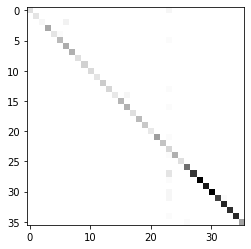

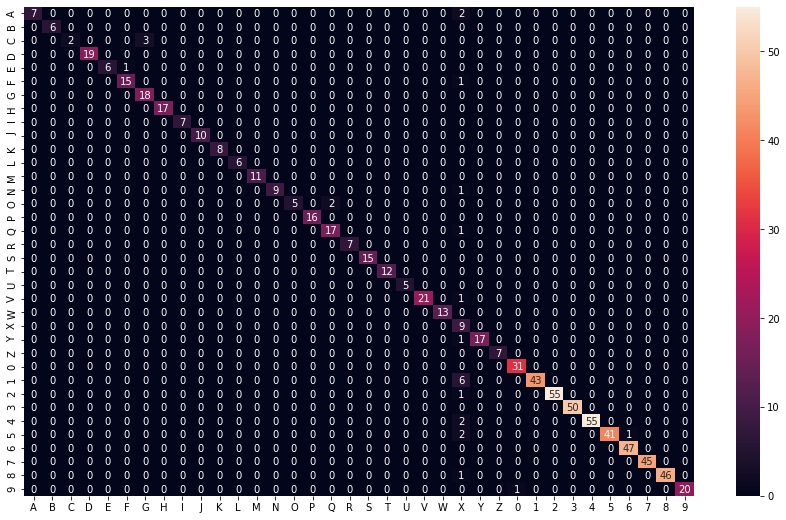

In [ ]:
print(yreal)
print(y_predict)
conf = sklearn.metrics.confusion_matrix(yreal, y_predict)
plt.imshow(conf, cmap='binary', interpolation='None')
plt.show()
df_cm = pd.DataFrame(conf, index = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"],
                  columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"])
plt.figure(figsize = (15,9))
sn.heatmap(df_cm, annot=True)

## Run cell to test model on randomly created images. 

['plate_AC16_2_0.png', 'plate_HC25_5_4.png', 'plate_OM66_7_0.png', 'plate_VG92_3_4.png']
Loaded 400 images from folder:
/content/testpictures
['plate_AC16_2_2.png', 'plate_HC25_5_4.png', 'plate_OM66_7_1.png', 'plate_WC36_6_1.png']
plate_AC16_2_2.png
/content/generatedset/plate_AC16_2_2.png
Loaded 263 images from folder:
/content/generatedset
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1315, 299, 150, 3)
(1315, 36)


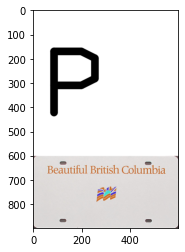

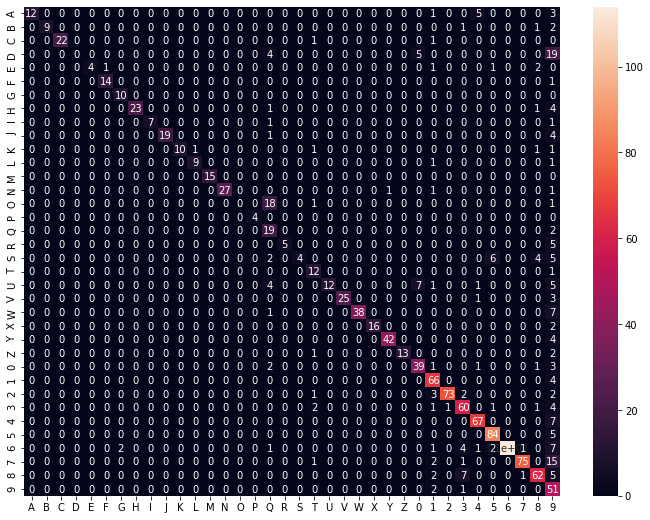

In [ ]:


path = "/content/"
!rm -rf testpictures
!mkdir testpictures
!rm -rf generatedset
!mkdir generatedset

NUMBER_OF_PLATES = 50

for i in range(0, NUMBER_OF_PLATES):

    # Pick two random letters
    plate_alpha = ""
    for _ in range(0, 2):
        plate_alpha += (random.choice(string.ascii_uppercase))

    # Pick two random numbers
    num = randint(0, 99)
    plate_num = "{:02d}".format(num)

    # Write plate to image
    blank_plate = cv2.imread(path+'blank_plate.png')

    # Convert into a PIL image (this is so we can use the monospaced fonts)
    blank_plate_pil = Image.fromarray(blank_plate)
    #blank_plate_pil_blank = Image.fromarray(blank_plate)

    # Get a drawing context
    draw = ImageDraw.Draw(blank_plate_pil)

    monospace = ImageFont.truetype("/content/drive/MyDrive/ENPH353/UbuntuMono-R.ttf", 200)
    draw.text((48, 105),plate_alpha + " " + plate_num, (255,0,0), font=monospace)

    # Convert back to OpenCV

    blank_plate = np.asarray([np.array(blank_plate_pil)])

    # Create parking spot label
    spotindex = i%8 + 1

    #s_blank = "P"
    #parking_spot_blank = 255 * np.ones(shape=[600, 600, 3], dtype=np.uint8)
    #cv2.putText(parking_spot_blank, s_blank, (30, 450), cv2.FONT_HERSHEY_PLAIN, 28,
    #            (0, 0, 0), 30, cv2.LINE_AA)
    #spot_w_blank_plate = np.concatenate((parking_spot_blank, blank_plate_pil_blank), axis=0)
    #cv2.imwrite(os.path.join(path + "pictures/", 
    #                         "aplate_{}.png".format("blank")),
    #                         spot_w_blank_plate)

    s = "P" + str(spotindex)
    parking_spot = 255 * np.ones(shape=[600, 600, 3], dtype=np.uint8)
    cv2.putText(parking_spot, s, (30, 450), cv2.FONT_HERSHEY_PLAIN, 28,
                (0, 0, 0), 30, cv2.LINE_AA)
    spot_w_plate = np.concatenate((parking_spot, blank_plate_pil), axis=0)
    spot_w_plate = cv2.copyMakeBorder(spot_w_plate,20,20,20,20,cv2.BORDER_CONSTANT,value=[255,0,0])

    # Convert back to OpenCV image and save
    # plate_numbersletters_parkingspot_variation.png
    cv2.imwrite(os.path.join(path + "testpictures/", 
                             "plate_{}{}_{}_{}.png".format(plate_alpha, plate_num, spotindex, 0)),
                             spot_w_plate)
    spot_w_plate = np.asarray([np.array(spot_w_plate)])
    #test function

    # Create data augmentor from Keras
    datagen = ImageDataGenerator(
      featurewise_center=False,
      samplewise_center=False,
      featurewise_std_normalization=False,
      samplewise_std_normalization=False,
      zca_whitening=False,
      zca_epsilon=1e-06,
      rotation_range=35,
      width_shift_range=0.0,
      height_shift_range=0.0,
      brightness_range=None,
      shear_range=50,
      zoom_range=0,
      channel_shift_range=0.0,
      fill_mode="nearest",
      cval=0.0,
      horizontal_flip=False,
      vertical_flip=False,
      rescale=0.6,
      preprocessing_function=None,
      data_format=None,
      validation_split=0.3,
      dtype=None,)
    
    aug_iter = datagen.flow(spot_w_plate)
    aug_plates = [next(aug_iter)[0].astype(np.uint8) for k in range(8)]
    # Write augmented license plates to file
    for j in range(0,7):
      cv2.imwrite(os.path.join(path + "testpictures/", 
                             "plate_{}{}_{}_{}.png".format(plate_alpha, plate_num,spotindex, j+1)),
                             aug_plates[j])

PATH = "/content/testpictures"
labels = !ls "{PATH}"
labels = labels[0].split()
print(labels)

def files_in_folder(folder_path):
  '''
  Returns a list of strings where each entry is a file in the folder_path.
  
  Parameters
  ----------
  
  folder_path : str
     A string to folder for which the file listing is returned.
     
  '''
  files_A = !ls "{folder_path}"
  # The files when listed from Google Drive have a particular format. They are
  # grouped in sets of 4 and have spaces and tabs as delimiters.
  
  # Split the string listing sets of 4 files by tab and space and remove any 
  # empty splits.
  files_B = [list(filter(None, re.split('\t|\s', files))) for files in files_A]
  
  # Concatenate all splits into a single sorted list
  files_C = []
  for element in files_B:
    files_C = files_C + element
  files_C.sort()
  
  return files_C

folder = PATH
dataset = files_in_folder(folder)

imgtestset = np.array([np.array((f'{folder}/{file}'))
                    for file in dataset[:]])
print("Loaded {:} images from folder:\n{}".format(imgtestset.shape[0], folder))

sift = cv2.xfeatures2d.SIFT_create()
img = cv2.imread("/content/drive/MyDrive/ENPH353/aplate_blank.png")

plt.imshow(img)
targetheight, targetwidth, _ = img.shape
kp_image, desc_image = sift.detectAndCompute(img, None)
# Feature matching
index_params = dict(algorithm=0, trees=5)
search_params = dict()
flann = cv2.FlannBasedMatcher(index_params, search_params)
for i in range(1,len(imgtestset)):
    frame = cv2.imread(imgtestset[i])
    #plate_{}{}_{}_{}.png
    #print(dataset[i])
    plate_alpha = dataset[i][6:8]
    #print(plate_alpha)
    plate_num = dataset[i][8:10]
    #print(plate_num)
    spotindex = dataset[i][11:12]
    #print(spotindex)


    grayframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # trainimage
    kp_grayframe, desc_grayframe = sift.detectAndCompute(grayframe, None)
    matches = flann.knnMatch(desc_image, desc_grayframe, k=2)
    good_points = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:
            good_points.append(m)

    if len(good_points) > 12:
        query_pts = np.float32([kp_image[m.queryIdx].pt for m in good_points]).reshape(-1, 1, 2)
        train_pts = np.float32([kp_grayframe[m.trainIdx].pt for m in good_points]).reshape(-1, 1, 2)
        matrix, mask = cv2.findHomography(query_pts, train_pts, cv2.RANSAC, 5.0)
        matches_mask = mask.ravel().tolist()

        # Perspective transform
        h, w, _ = img.shape
        pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, matrix)
        #print(np.int32(dst))
        homography = cv2.polylines(frame, [np.int32(dst)], True, (255, 0, 0), 3)
        # plt.figure(str(i) + "matched")
        # plt.imshow(frame)
        # plt.show()
        
        #If plate is identified, stretch it and save it.
        rect_pts = np.int32(dst).reshape(4,2)
        rect = np.zeros((4,2), dtype = "float32")
        # the top-left point has the smallest sum whereas the
        # bottom-right has the largest sum
        s = rect_pts.sum(axis = 1)
        rect[0] = rect_pts[np.argmin(s)]
        rect[2] = rect_pts[np.argmax(s)]
        # compute the difference between the points -- the top-right
        # will have the minumum difference and the bottom-left will
        # have the maximum difference
        diff = np.diff(rect_pts, axis = 1)
        rect[1] = rect_pts[np.argmin(diff)]
        rect[3] = rect_pts[np.argmax(diff)]

        # now that we have our rectangle of points, let's compute
        # the width of our new image
        (tl, tr, br, bl) = rect
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        # ...and now for the height of our new image
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        # take the maximum of the width and height values to reach
        # our final dimensions
        maxWidth = max(int(widthA), int(widthB))
        maxHeight = max(int(heightA), int(heightB))
        # construct our destination points which will be used to
        # map the screen to a top-down, "birds eye" view
        dst = np.array([
          [0, 0],
          [targetwidth - 1, 0],
          [targetwidth - 1, targetheight - 1],
          [0, targetheight - 1]], dtype = "float32")
        # calculate the perspective transform matrix and warp
        # the perspective to grab the screen
        M = cv2.getPerspectiveTransform(rect, dst)
        warp = cv2.warpPerspective(frame, M, (targetwidth, targetheight))

        # plt.figure(str(i) + "warped")
        # plt.imshow(warp)
        # plt.show()
        #print(warp.shape)
        path = "/content/"
        cv2.imwrite(os.path.join(path + "generatedset/", 
                             "plate_{}{}_{}_{}.png".format(plate_alpha, plate_num,spotindex, i % 8 + 1)),
                       warp)
    else:
        
        framenotmatched = cv2.drawMatches(img, kp_image, grayframe, kp_grayframe, good_points, grayframe)
        # plt.figure(str(i) + "notmatched")
        # plt.imshow(framenotmatched)
        # plt.show()
PATH = "/content/generatedset"
labels = !ls "{PATH}"
labels = labels[0].split()
print(labels)
folder = PATH
warpedset = files_in_folder(folder)
print(warpedset[0])
print(f'{folder}/{warpedset[0]}')
imgtestsetwarped = np.array([np.array((f'{folder}/{file}'))
                    for file in warpedset[:]])
print("Loaded {:} images from folder:\n{}".format(imgtestsetwarped.shape[0], folder))
X_datatestset = []
Y_datatestset = []


np.random.shuffle(imgtestsetwarped)
#parses image and adds labels/images to dataset
def croplicenseimage( plate):
    im = Image.open(plate)
    w,h = im.size
    # print(h)
    # print(w)
    index = 0
    #split spot number and plate into seperate images
    for index in range (0,4):
      area = (w*index/4, 2*h/3, w*index/4 + w/4, h)
      cim = im.crop(area)
      imagename = plate[len(plate) - 12 + index] + "_" + str(index) + ".png"
      
      #ignoring index of image
      _, onehotlabel =  labelimage(imagename)

      Y_datatestset.append(onehotlabel)
      X_datatestset.append(cim)
      # plt.figure(i)
      # plt.title(imagename)
      # plt.imshow(cim)
      # plt.show()

    
    area = (w/2, 0, w, 2*h/3)
    cim_pre = im.crop(area)
    dim = (int(w/4), int(h/3))
    cim = cv2.resize(np.asarray(cim_pre), dim)
    imagename = plate[len(plate) - 7] + "_" + str(0) + ".png"
      
    #ignoring index of image
    _, onehotlabel =  labelimage(imagename)

    Y_datatestset.append(onehotlabel)
    X_datatestset.append(cim)
    # plt.figure(i+4)
    # plt.title(imagename)
    # plt.imshow(cim)
    # plt.show()

#create one hot key for given cropped image.
#return the 'index' of the number on the plate and return the 'label' that hold the vector of the inputted image.

def labelimage(plateID):
    encodingkey = {'A' : 0, 'B': 1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9, 'K':10, 'L':11, 'M':12, 'N':13, 'O':14, 'P':15, 'Q':16, 'R':17, 'S':18, 'T':19,'U':20,'V':21, 'W':22, 'X':23, 'Y':24, 'Z':25,'0': 26,'1':27,'2':28, '3':29, '4':30, '5':31,'6':32, '7':33,'8':34, '9':35}
    plate = plateID[0]
    index = plateID[2]
    label = np.zeros(36)
    label[encodingkey[str(plate)]] = 1
    return index, label


for img in imgtestsetwarped[:]:
    croplicenseimage(img)

print(Y_datatestset[0])

X_datatestset2 = [np.asarray(i)/255 for i in X_datatestset]
X_datatestset2 = np.asarray(X_datatestset2)
Y_datatestset2 = np.asarray(Y_datatestset)


print(X_datatestset2.shape)
print(Y_datatestset2.shape)

def predictimage():
  y_predict = []

  for index in range(0,len(Y_datatestset2)):
    img = X_datatestset2[index]
    img_aug = np.expand_dims(img, axis=0)
    y_predict.append(np.argmax(conv_model.predict(img_aug)[0]))
  return y_predict

y_predict = np.round(predictimage(),0)
yreal = []
for i in range(0,len(Y_datatestset2)):
    yreal.append(np.argmax(Y_datatestset2[i]))


conf = sklearn.metrics.confusion_matrix(yreal, y_predict)

df_cm = pd.DataFrame(conf, index = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"],
                  columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"])
plt.figure(figsize = (12,9))
sn.heatmap(df_cm, annot=True)

In [ ]:
sklearn.metrics.accuracy_score(yreal, y_predict, normalize=True)

0.8076045627376426

In [ ]:
conv_model.save('/content/drive/MyDrive/ENPH353/detection_CNN')